# 1-C Nonlinear Covid-19 Epidemic Model and Prediction 

A Julia implementation of following J-P Quadrat's papers:
- [1-C Nonlinear Covid-19 Epidemic Model and Application to the Epidemic Prediction in France](https://www.medrxiv.org/content/10.1101/2020.05.24.20111807v1)
- [A simple Covid-19 Epidemic Model and Containment Policy in France](https://www.medrxiv.org/content/10.1101/2020.04.25.20079434v1)

In [1]:
using Plots, DifferentialEquations;

## Utility functions

In [2]:
# One day step derivation
function derivative(y)
    DT = 1;                # Delta Time = 1 day
    M = size(y, 1);        # Number of elements
    y0 = y[1:M-DT];
    y1 = y[1+DT:M];
    return (y1 .- y0) ./ DT;
end

derivative (generic function with 1 method)

In [3]:
# Facade to plot() function: show over days daily infected people and
# prediction of coming infected people.
#
# simulated: prediction of daily infected
# observed: real daily infected
# title: title of the plot
# position: position of the legend
function RecipesBase.plot(simulated, observed, title, position=:topright)
    plot(observed,
        title = title,
        xlabel = "Days",
        ylabel = "Daily Infected",
        label = "observation",
        legend = position)
    plot!(simulated, label="Prediction")
end

## Covid-19 Epidemic Model and Prediction

In [4]:
# Given r, get the a and b coefs of: a * log(accumul)^r + b
# where: accumul is the accumulation of infected people.
# return: a and b coefs. Return initial value for the solver.
function model(accumul, r)
    # Logarithm of accumulated infected people
    accumul = log.(accumul)
    
    # Linear regression: y = a x + b
    x, y = accumul[1:end-1] .^ r, derivative(accumul)
    b, a = [ones(size(x, 1)) x] \ y
    
    return b, a, accumul[1]
end

model (generic function with 1 method)

In [5]:
function simulation(f::Function, u0, tend, days)    
    # ODE
    tspan = (0.0, tend)
    prob = ODEProblem(f, u0, tspan)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
    
    # Solution up to X days:
    tend = tend + days
    derivative(exp.(sol(1:tend)))
end

simulation (generic function with 1 method)

In [6]:
# First wave prediction
# accumul: accumulated contamined-tested people.
# r: a * log(accumul)^r + b (default: a * log(accumul) + b)
# days: previtions up to X days (default: 1 month)
# title: title of the plot
# position: position of the legend (default: top right)
function prediction(accumul; r=1.0, days=30, title, position=:topright)
    b, a, u0 = model(accumul, r)
    f(u, p, t) = (u .^ r) .* a .+ b
    sim = simulation(f, u0, size(accumul, 1), days)
    plot(sim, derivative(accumul), title, position)
end

prediction (generic function with 1 method)

In [16]:
# Multi waves prediction
function prediction2(accumul; r=1.0, p=30, days=7, title, position=:topright)
    sim = zeros(size(accumul,1) + days)
    for i = 1:size(accumul,1)-p
        b, a, u0 = model(accumul[i:i+p], r)
        f(u, p, t) = (u .^ r) .* a .+ b
        res = simulation(f, u0, size(accumul[i:i+p], 1), days)
        sim[i+p+days] = res[end]
    end

    plot(sim, derivative(accumul), title, position)
end

prediction2 (generic function with 1 method)

TODO: sous echantillone accumul: 1 point par semaine puis changer derivee pour prendre la moyenne entre les deux points

## Observations by country

Inputs: accumulated contamined-tested people. For France: https://www.gouvernement.fr/info-coronavirus/carte-et-donnees ("cas confirmés").

In [7]:
# France (last point: August 24th 2020)
frAccumulInf = [13.0, 18, 38, 57, 100, 130, 191, 212, 285, 423, 613, 949, 1126, 1412, 1784, 2281, 2876,
    3661, 4500, 5423, 6633, 7730, 9134, 10995, 12612, 14459, 16689, 19856, 22302, 25233, 29155, 32964,
    37575, 40174, 44450, 52128, 56989, 59105, 64338, 68605, 70478, 74390, 78167, 82048, 86334, 90676,
    93790, 95403, 98076, 103573, 106206, 108847, 109252, 111821, 112606, 114657, 117324, 119151, 120804,
    122577, 124114, 124575, 125770, 126835, 128442, 129581, 130185, 130979, 131287, 131863, 132967, 137150,
    137779, 138421, 138854, 139063, 139519, 140227, 140734, 141356, 141919, 142291, 142411, 142903, 143427,
    143845, 144163, 144566, 144806, 144921, 145279, 145555, 145746, 149071, 149668, 151496, 151753, 152091,
    151325, 151677, 152444, 153055, 153634, 153977, 154188, 154591, 155136, 155561, 156287, 156813, 157220,
    157372, 157716, 158174, 158641, 159452, 160093, 160277, 160750, 161267, 161348, 161348, 162936, 163454,
    163980, 164260, 164801, 165719, 166378, 166960, 167711, 168159, 168335, 168810, 169473, 170094, 170752,
    171504, 172089, 172377, 172888, 173304, 173838, 174674, 175639, 176404, 176754, 177338, 178336, 179398,
    180528, 180528, 180528, 183079, 183804, 185196, 186573, 187919, 189547, 190739, 191295, 192334, 194029,
    195633, 197921, 200105, 201990, 202775, 204172, 206696, 209365, 212211, 215521, 218536, 219029, 221267,
    225043, 229814, 234400, 238002, 242899, 244854]

# France, second wave starts at this point
frSecondWave = 100

# Deutschland
deAccumulInf = [18.0, 21, 26, 53, 66, 117, 151, 188, 240, 400, 639, 795, 902, 1139, 1296, 1567, 2369, 3062, 3795, 4838,
    6012, 7156, 8198, 10999, 13957, 16662, 18610, 22672, 27436, 31554, 36508, 42288, 48582, 52547, 57298, 61913,
    67366, 73522, 79696, 85778, 91714, 95391, 99225, 103228, 108202, 113525, 117658, 120479, 123016, 125098, 127584,
    130450, 133830, 137439, 139897, 141672, 143457, 145694, 148046, 150383, 152438, 154175, 155193, 156337,
    157641, 159119, 160758, 161703, 162496, 163175, 163860, 164807, 166091, 167300, 168551, 169218]

# Italia
itAccumulInf = [322.0, 400, 650, 888, 1128, 1694, 2036, 2502, 3089, 3858, 4636, 5883, 7375, 9172, 10149, 12464,
    15113, 17660, 21157, 24747, 27980, 31506, 35713, 41035, 47021, 53578, 59138, 63927, 69176, 74386, 80539,
    86498, 92472, 97689, 101739, 105792, 110574, 115242, 119827, 124632, 128948, 132547, 135586, 139422, 143626,
    147577, 152271, 156363, 159516, 162488, 165155, 168941, 172434, 175925, 178925, 181228, 183957, 187327, 189873,
    192994, 195351, 197675, 199414, 201505, 203591, 205463, 207428, 209328, 210717, 211938, 213013, 214457, 215858,
    217185, 218368, 219070, 219814, 221216, 222104, 223096, 223885, 224860, 225435, 225886, 226699, 227364, 228006,
    228658, 229327, 229858, 230158, 230555, 231139, 231732, 232248, 232664, 232997, 233197, 233515, 233836, 234013,
    234531, 234801, 234998, 235278, 235561, 235763, 236142, 236305, 236651, 236989, 237290, 237500, 237828, 238159,
    238011, 238275, 238499, 238720, 238833, 239410, 239706, 239961, 240136, 240310, 240436, 240578, 240760, 240961,
    241184, 241419, 241611, 241819, 241956, 242149, 242363, 242639, 242827, 243061, 243320, 243344, 243506, 243736,
    243967, 244216, 244434, 244624, 244752, 245032, 245338, 245590, 245864, 246118, 246286];

# Spain
spAccumulInf = [125, 169, 228, 282, 365, 430, 674, 1231, 1695, 2277, 3146, 5232, 6391, 7553, 9191, 11178, 13716, 
    17147, 20071, 25002, 29843, 33089, 39669, 47610, 56188, 64059, 72248, 78795, 85195, 94417, 102136, 110238,
    117710, 124736, 130759, 135032, 140510, 146690, 152446, 157022, 161852, 166019, 169196, 172541, 177633, 182816,
    188068, 191726, 195944, 200210, 204178, 208389, 213024, 219764, 223759, 207764, 209465, 210743, 212917, 213435,
    215216, 216582, 217466, 218011, 219329, 220325, 221447, 222857, 223578, 224390, 227436, 228030];

In [ ]:
#plot(plot(frInfected), plot(itInfected), plot(deInfected), plot(spInfected))

## Simulations

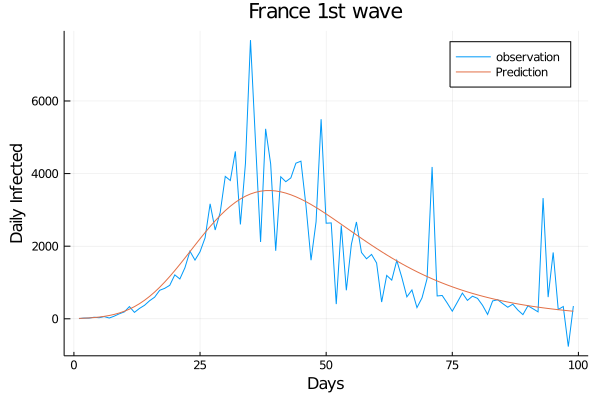

In [8]:
prediction(frAccumulInf[1:frSecondWave], r=1.5, days=0, title="France 1st wave")

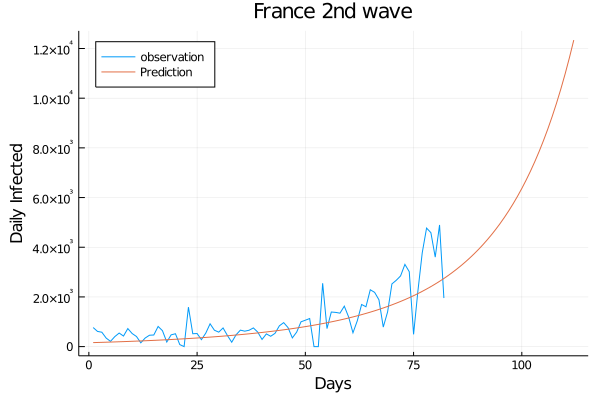

In [15]:
prediction(frAccumulInf[frSecondWave:end], r=1.0, days=30, title="France 2nd wave", position=:topleft)

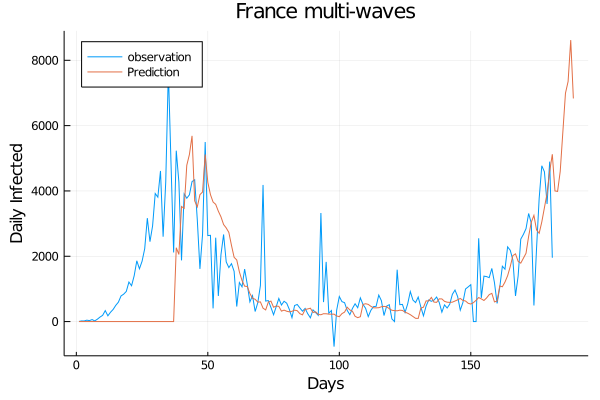

In [17]:
prediction2(frAccumulInf, r=2.0, p=30, days=7, title="France multi-waves", position=:topleft)

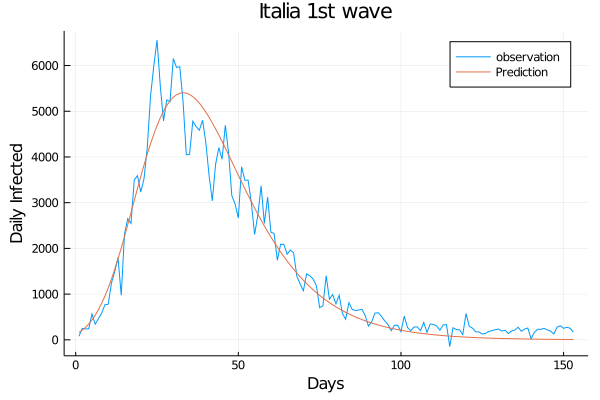

In [10]:
prediction(itAccumulInf[1:end], r=1.8, days=0, title="Italia 1st wave")

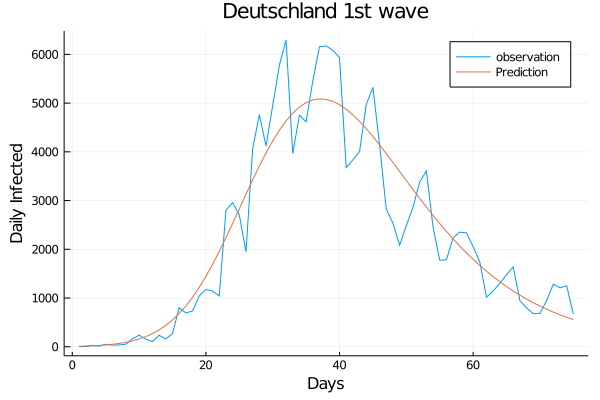

In [11]:
prediction(deAccumulInf[1:end], r=3.0, days=0, title="Deutschland 1st wave")

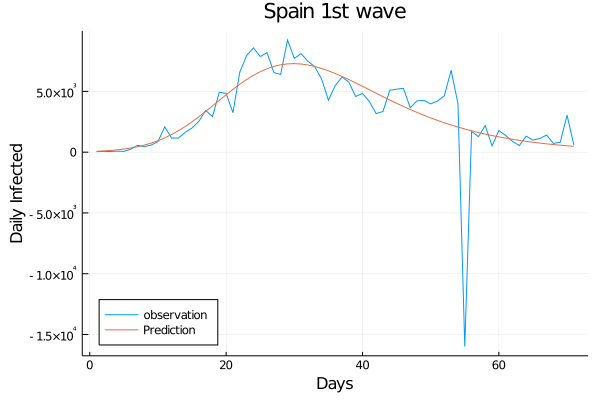

In [12]:
prediction(spAccumulInf[1:end], r=3.0, days=0, title="Spain 1st wave", position=:bottomleft)